In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import pyproj

In [2]:
#carga del dataset
data = gpd.read_file("data_seleccion.csv", encoding='latin1')
data.head(2)

,field_1,place_name,price_usd_per_m2,surface_total_in_m2,lat,lon,floor,rooms,description,title,...,pileta,patio,terraza,lavadero,Belgrano,NuÃ±ez,Palermo,Palermo Hollywood,Recoleta,geometry
0,7,Belgrano,3066.666666666666,45.0,-34.5598729,-58.443362,,,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,...,1,0,1,1,1,0,0,0,0,None
1,8,Belgrano,3000.0,65.0,-34.5598729,-58.443362,,,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",...,1,0,1,1,1,0,0,0,0,None


In [3]:
#lista con barrios seleccionados
data.groupby('place_name')['place_name'].nunique()


place_name
Barrio Norte         1
Belgrano             1
NuÃ±ez               1
Palermo              1
Palermo Hollywood    1
Recoleta             1
Name: place_name, dtype: int64

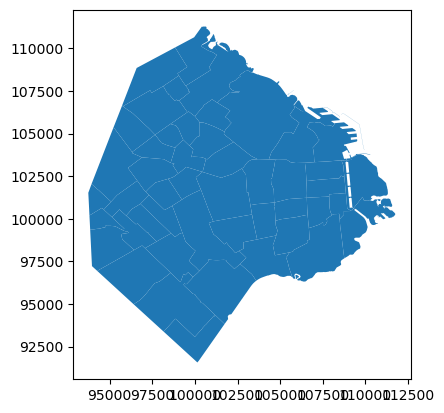

In [4]:
#carga de shapeline
barrios_shp = gpd.read_file("barrios_caba/barrios_censo_2010.shp") 
barrios_shp.plot() 

In [5]:
# verificar el sistema de coordenadas actual
print(barrios_shp.crs)
print('------')
print(data.crs)

PROJCS["Gauss Krugger BA",GEOGCS["Campo Inchauspe",DATUM["Campo_Inchauspe",SPHEROID["International 1924",6378388,297,AUTHORITY["EPSG","7022"]],AUTHORITY["EPSG","6221"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4221"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",-34.6297166],PARAMETER["central_meridian",-58.4627],PARAMETER["scale_factor",1],PARAMETER["false_easting",100000],PARAMETER["false_northing",100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
------
None


In [10]:
# necesario para que las coordenadas del shapeline esten iguales al del dataset
barrios_shp = barrios_shp.to_crs(epsg=4326)
barrios_shp.head(1)

,BARRIOS,COMUNA,NUM_DE_BAR,geometry
0,AGRONOMIA,15,1,"POLYGON ((-58.47597 -34.59192, -58.47712 -34.5..."


In [13]:
#obtencion de puntos gps de la columna lat y long, a formato geoespacial o geometry
ubicacion_appartments = gpd.points_from_xy(data.lon, data.lat)
ubicacion_appartments

<GeometryArray>
 ...
Length: 4688, dtype: geometry

In [15]:
#incorporación de datos geosatelitales a columna geometry creada por geopandas
data = gpd.GeoDataFrame(data, geometry= ubicacion_appartments)
data.tail(2)

,field_1,place_name,price_usd_per_m2,surface_total_in_m2,lat,lon,floor,rooms,description,title,...,pileta,patio,terraza,lavadero,Belgrano,NuÃ±ez,Palermo,Palermo Hollywood,Recoleta,geometry
4686,121160,Belgrano,2611.464968152867,157.0,-34.563685346,-58.4426825896,,,Edificio en esquina de muy buena categorÃ­a de...,Av .Luis Maria Campos 1400- Belgrano-Capital F...,...,0,0,0,1,1,0,0,0,0,POINT (-58.44268 -34.56369)
4687,121209,Belgrano,2611.464968152867,157.0,-34.563685346,-58.4426825896,,,Edificio en esquina de muy buena categorÃ­a de...,Av .Luis Maria Campos 1400- Belgrano-Capital F...,...,0,0,0,1,1,0,0,0,0,POINT (-58.44268 -34.56369)


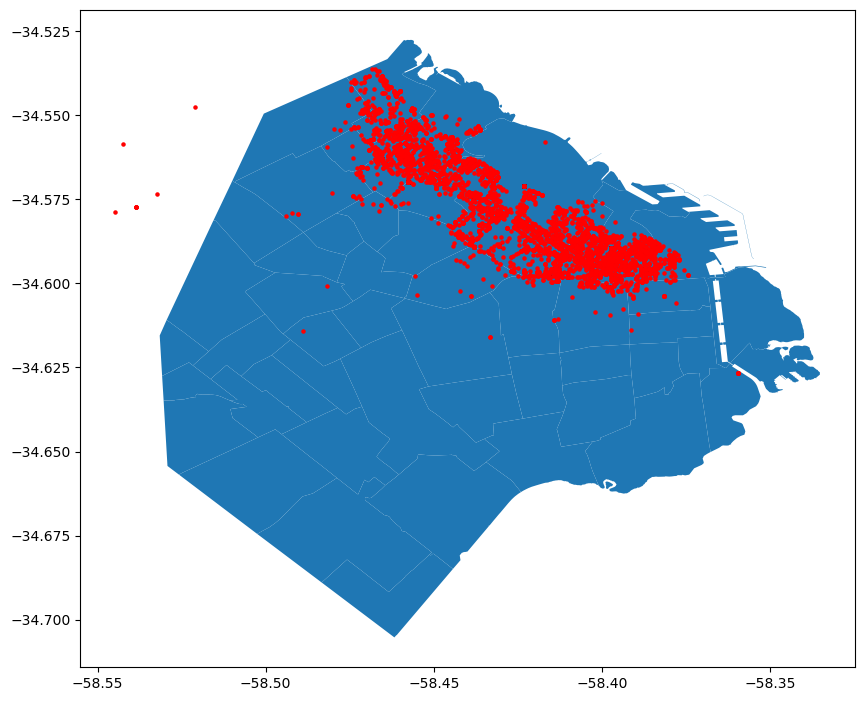

In [16]:
#plot con propiedades outliers
fig, ax = plt.subplots(figsize=(10, 10))
barrios_shp.plot(ax=ax)
data.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show()

In [ ]:
#punto referencia al obelisco
from shapely.geometry import Point
obelisco = Point(-58.3815704,-34.6037389) # Dato geoespacial de obelisco
df_obelisco = pd.DataFrame(data = {'id': [1]}) # Armo un DataFrame
geo_obelisco = gpd.GeoDataFrame(df_obelisco, geometry=[obelisco]) # Lo transformo en GeoDataFrame
geo_obelisco

In [ ]:
#total_bounds devuelve una tupla con las coordenadas xmin, ymin, xmax, ymax que representan las coordenadas de extensión del shapefile
# longitud
xmin = barrios_shp.total_bounds[0]
xmax = barrios_shp.total_bounds[2]
# latitud
ymin = barrios_shp.total_bounds[1]
ymax = barrios_shp.total_bounds[3]

# Recortar data para dejar solo los puntos dentro del shapefile
data = data.cx[xmin:xmax,ymin:ymax]

fig, ax = plt.subplots(figsize=(10, 10))
barrios_shp.plot(ax=ax)
data.plot(ax=ax, marker='o', color='cyan', markersize=3)
geo_obelisco.plot(ax=ax, marker='o', color='red', markersize=15)
plt.show()

In [ ]:
import geopy.distance

#punto obelisco requerido para utilizar la función
geo_obelisco_x = geo_obelisco.iloc[0]['geometry'].x
geo_obelisco_y=  geo_obelisco.iloc[0]['geometry'].y

p_obelisco = (geo_obelisco_x,geo_obelisco_y)



for i in data.index:
    data.loc[i, 'distancia'] = geopy.distance.geodesic(p_obelisco,
                  (data.loc[i,'geometry'].x
                  ,data.loc[i,'geometry'].y)).kilometers



In [ ]:
data